# Setup - defining parameters

In [28]:

#thresholds for spot detection (*std)
sigma1=60     #sigma of threshold for finding spots
sigma2=15     #sigma of threshold for calculating moments

#other spot detection parameters - probably won't need to change
boxFind=7     #size of box for finding spots
boxCent=6     #size of box for centroiding
nmin=10       #minimum number of acceptable pixels in a spot
nmax=90       #maximum number of acceptable pixels in a spot
maxIt=20      #maximum number of iterations for centroiding

#set to non zero to override automatic fwhm determination. 
fwhmx=0
fwhmy=0

#inter = 1 for notebook, 0 for scripts, cenFlag='local' for local, 'db' to read from database
inter=1
cenFlag='local'
#cenFlag='db'

#dataSource - set to 'pinhole' for pinhole mask, 'taichung' for lab data. 

dataType='pinhole'

#conifguration for rotator center

config="oct18"

#database info - update as needed
user='pfs'
passwd='fps'
host='133.40.164.208'
dbname='pfspass'
conn=None


# Setup - importing

In [16]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sigmaclip
import sys

#kludge - need to change???
sys.path.append("/Users/karr/Science/PFS/NewCode/Code/pfs_utils/python/pfs/utils/coordinates/")
import CoordTransp
import DistortionCoefficients
from importlib import reload  #for debugging purposes

#the try/except is for using in the MHS environment, or standalone. 

try:
    import mcsActor.Visualization.mcsRoutines as mcs
except:
    import mcsRoutines as mcs

try:
    import mcsActor.Visualization.fpsRoutines as fps
except:
    import fpsRoutines as fps

try:
    import mcsActor.Visualization.visRoutines as vis
except:
    import visRoutines as vis

try:
    import mcsActor.Visualization.vis_plot as visplot
except:
    import vis_plot as visplot




# connect to database

In [6]:

reload(vis)
#connect to database if in DB mode
if(cenFlag=='db'):
    conn=vis.dbConnect(user=user,dbname=dbname,passwd=pfspass,host=host)
    
#read instrument parameters if available
if(config != "calib"):
    rotCent,offset=vis.loadInstParams(config)


# parameters that change for each run

In [29]:

#set frame ID minimum and maximum values (inclusive)

frameID=3666

#source directory data files in local mode
sourceDir="/Users/karr/Science/PFS/Firsts/"
fPref="PFSC"

#subtitle for plots - currently set to first frame ID plus tag
stitle=""

#get list of file names
fname,prefix=vis.getFileName(frameID,sourceDir,fPref,'pinhole')


## expected get positions of cobras

# calculate threshold values and region (once per config)

In [30]:
#not needed if pulling from DB
reload(vis)
reload(fps)
reload(mcs)
config='calib'

if((cenFlag=='local')):
    
    image=vis.getImage(fname)

    #if config is not known, find the region (must be rotate by multiple of 90 degrees)
    if(config=='calib'):
        xrange,yrange=mcs.getRegion(image,4,2)
        thresh1,thresh2,xrange,yrange=mcs.getThresh(image,xrange,yrange,sigma1,sigma2)
        
    #if config is known, calculate the region for the threshold from the coord transforms
    else:
        xrange,yrange=mcs.getAutoThresh(image,4,2,rotCent,offset)
        

print("Thresholds=",thresh1,thresh2)
print("Boundaries of region (x1,x2,y1,y2): ",xrange[0],xrange[1],yrange[0],yrange[1])


Thresholds= 1851.9620529832034 1096.7449356347047
Boundaries of region (x1,x2,y1,y2):  2096 5777 2712 6666


# Do the centroiding for a set of database, either locally or retrieve from DB


(3446,) 793.1796380127207


<IPython.core.display.Javascript object>


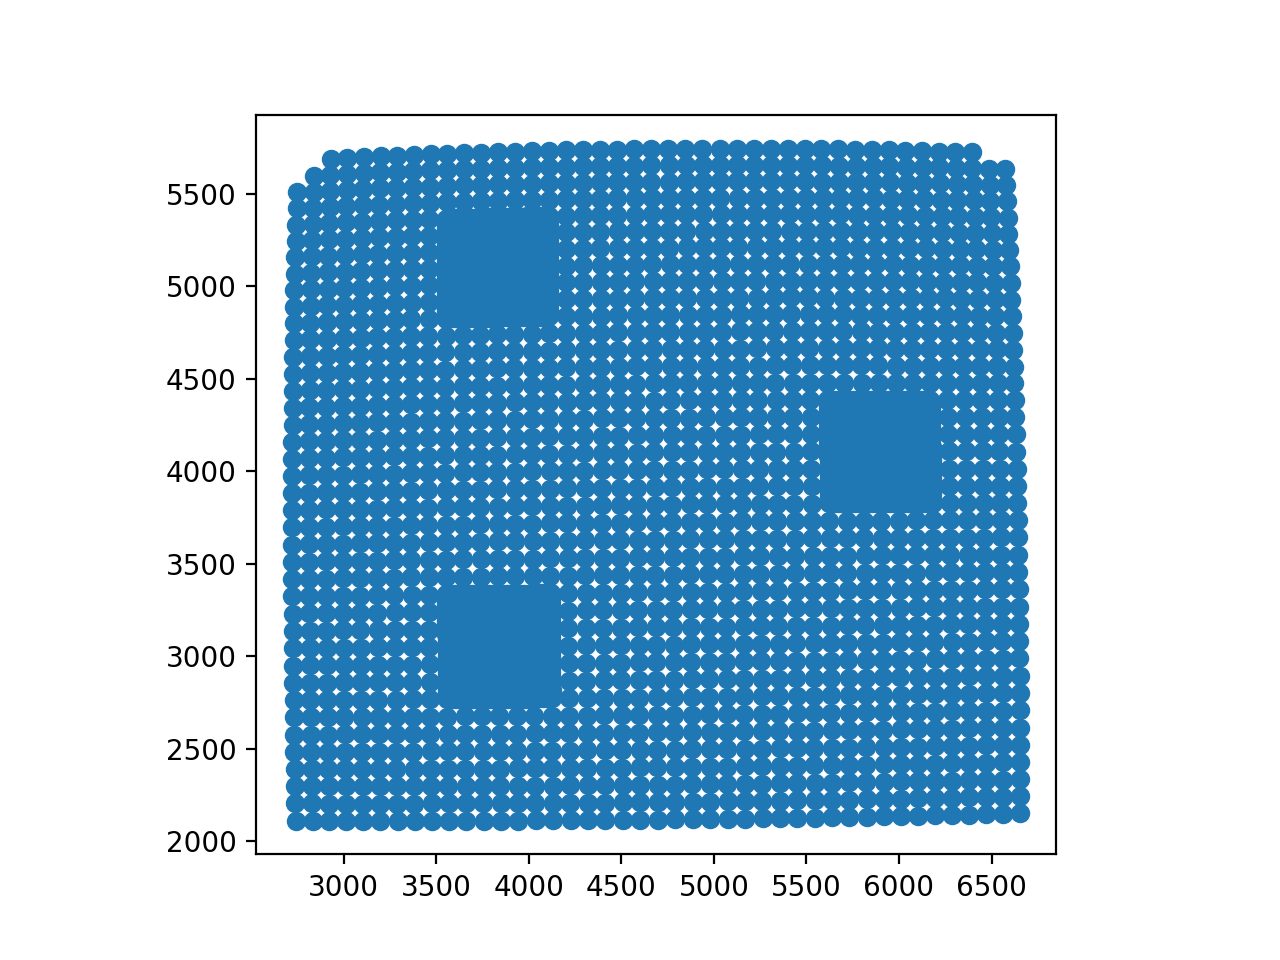

In [37]:
reload(vis)

reload(visplot)

#set redo=1 to recalculate values, redo=0 to read from files    
redo=1


#local case - either read files and calculate, or load data from a file. 
if(cenFlag=="local"):
    image=vis.getImage(fname)

    boxFind=10
    centroids=vis.getCentroids(image,thresh1*0.7,thresh2,fwhmx,fwhmy,boxFind,boxCent,nmin,nmax,maxIt)
    x=centroids[:,1]
    y=centroids[:,2]
    #db case - read from database
elif(cenFlag=='db'):
    printf("Loading Centroids from DB.")
    centroids=vis.getCentroidsDB(conn,frameIDs)        
         
visplot.checkCentroids(x,y,1,prefix,inter)


Scaling


<IPython.core.display.Javascript object>


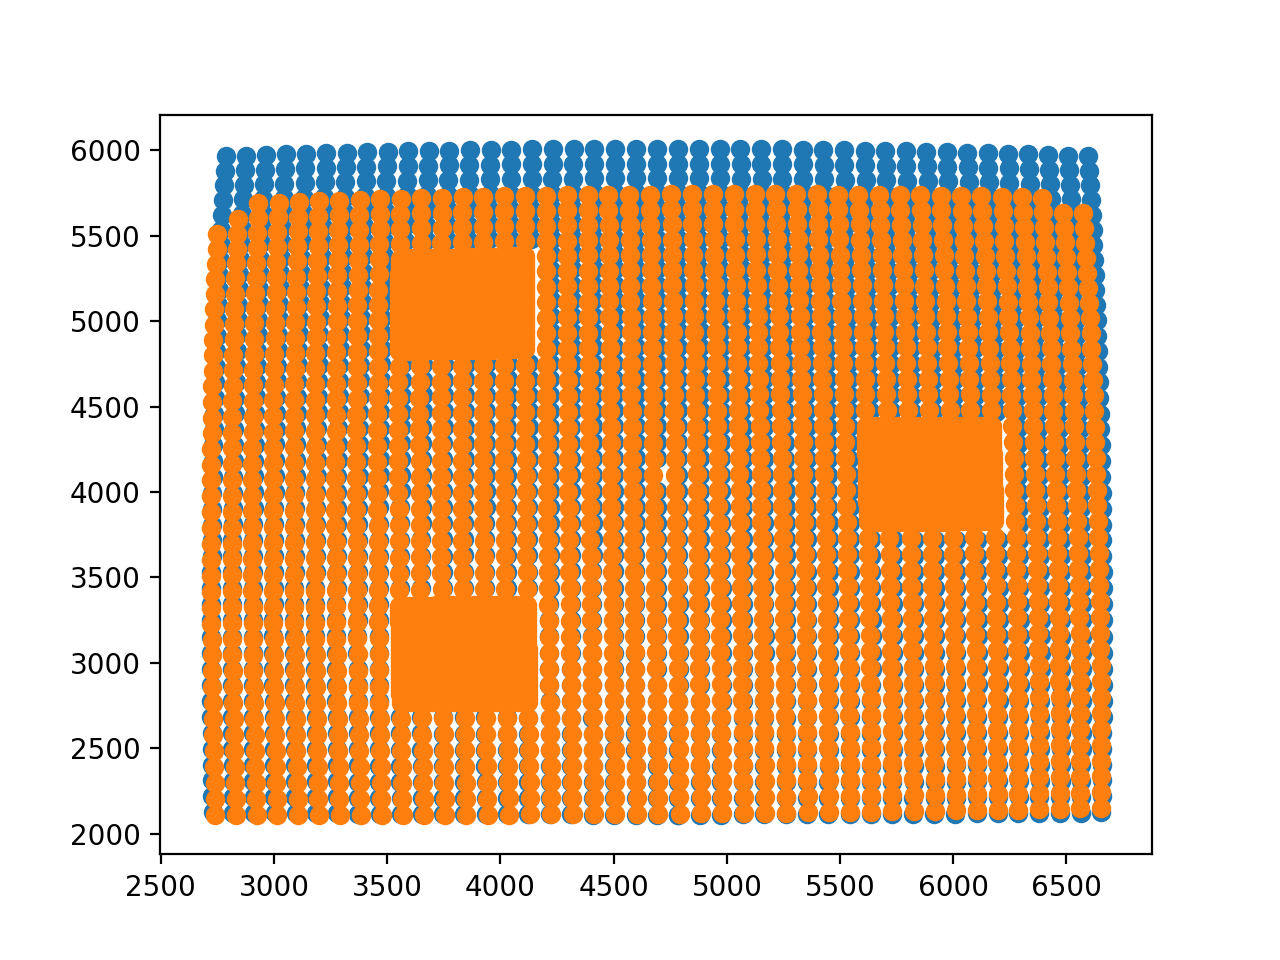

In [102]:
config='oct18'
reload(fps)
reload(mcs)
reload(vis)
inr=180
za=0
fiducials,scienceFibres=fps.getFieldDefinition(config)
offset=[0,-85]
fibres=fps.getFibrePos(fiducials,scienceFibres,za,inr,rotCent,offset)

fig,ax=plt.subplots()
ax.scatter(fibres[:,1],fibres[:,2])
ax.scatter(x,y)

fig.show()





In [104]:
reload(mcs)

#match all the frames to the first frame
tol=50
mCentroids=mcs.findHomes(centroids,fibres,tol)
mCentroids.shape

(1703, 8)


# Image Quality Plots

Now we get into the analysis part. 

Plots of FWHM values, peak values, and a rough calculation of total flux.  Set plotrange to the range you want for the colour bar (2 element numpy array); the default is min and max. 


In [ ]:
reload(visplot)

plotRange=None
nbins=30


plotRange=[1,5]
visplot.pairPlot(mCentroid[:,0],mCentroid[:,1],mCentroid[:,2],mCentroid[:,2],plotRange,"FWHM (x)",prefix,"_fwhmx","FWHM (x)","pixels",nbins,inter,stitle=stitle)
plotRange=[2,8]
visplot.pairPlot(mCentroid[:,0],mCentroid[:,1],mCentroid[:,3],mCentroid[:,3],plotRange,"FWHM (y)",prefix,"_fwhmy","FWHM (y)","pixels",nbins,inter,stitle=stitle)
plotRange=[2,8]
visplot.pairPlot(mCentroid[:,0],mCentroid[:,1],mCentroid[:,5],mCentroid[:,5],plotRange,"Peak",prefix,"_peak","Peak","",nbins,inter,stitle=stitle)


# Distortion Plots

Calculations and plots for distortion of a single field. The results are plotted in three forms; quiver, colour map in mm units, colour map in units of % of the field size. 


<IPython.core.display.Javascript object>


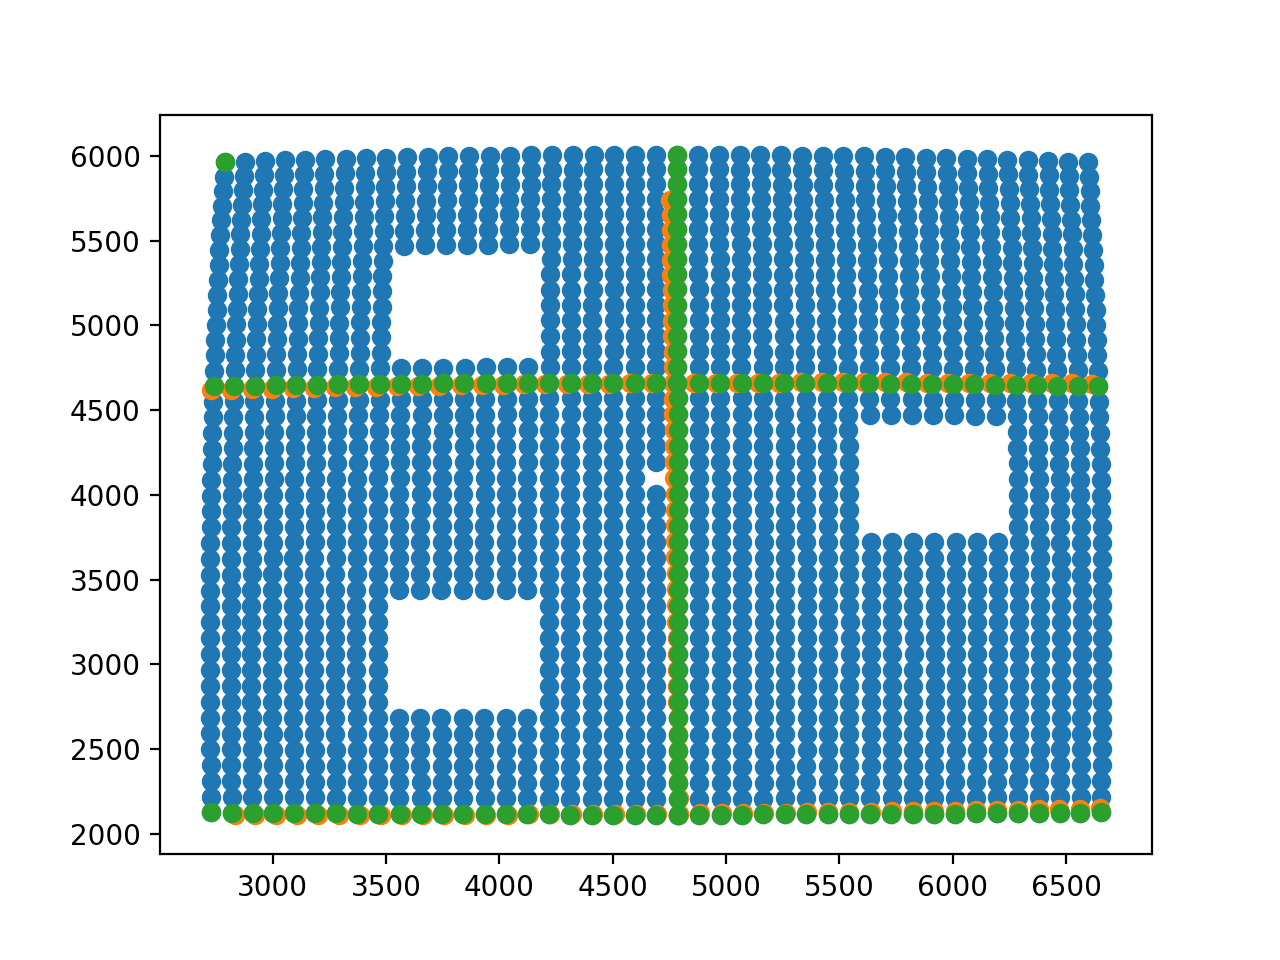

In [105]:
fig,ax=plt.subplots()
ax.scatter(fibres[:,1],fibres[:,2])
ax.scatter(mCentroids[1:130,1],mCentroids[1:130,2])
ax.scatter(fibres[0:130,1],fibres[0:130,2])
fig.show()

In [45]:
fibres[:,1].shape

(3,)

In [71]:
mCentroids.shape

(1703, 8)

In [62]:
len(fibres[0,:])

3